In [1]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."));

In [2]:
using JuMP
using BARON
using LinearAlgebra
using Parameters
using MINLPTrajOpt

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.0/BARON/kb9Tq.ji for BARON [2e2ca445-9e14-5b13-8677-4410f177f82b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.0/MINLPTrajOpt/myGxE.ji for MINLPTrajOpt [c68a6224-cbe5-11e8-1e7f-b1d3117b2aa4]
└ @ Base loading.jl:1184


The optimizer is clearly exploiting numerical issues due to the primitive integration scheme, injecting energy by searching for instability.

TODO:

* Running state cost
* AxisArrays for sanity
* Better discretization of the continuous time dynamics
* Think about better integration schemes
  * Central differencing for accelerations
  * Semi-implicit Euler
  * Energy flow constraints
  * Variable time steps
* Keep track of total energy
* Compare to COUENNE

In [3]:
solver = BaronSolver(threads=Sys.CPU_THREADS)
parameters = PendulumParameters()
τmax = parameters.m * parameters.g * parameters.l * 0.7
θ0 = -0.1
θd0 = 0.0
T = 8.0 #4.5 #4.5
N = 40
Δt = T / N
problem = PendulumSwingUpProblem(parameters, (θ0, θd0), solver;
    τmax = τmax, Δt=Δt, N=N);

In [4]:
status = solve(problem.model)
@assert status == :Optimal

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  2015.84311624     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  1922.29829780   

In [5]:
# problem.model.internalModel.probfile

In [6]:
include(joinpath(dirname(pathof(MINLPTrajOpt)), "..", "extras", "plotting.jl"));

In [7]:
t = range(0.0, stop=T, length=N)
Δθ = atan.(getvalue.(problem.sΔθ) ./ getvalue.(problem.cΔθ))
θ = θ0 .+ cumsum(Δθ)
τ = getvalue.(problem.τ)
θdd = getvalue.(problem.θdd);

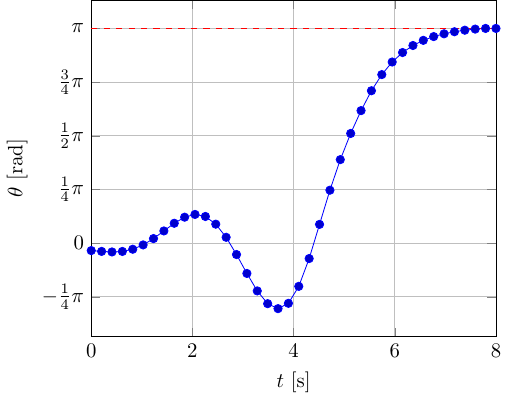

In [8]:
p = timeplot(t, θ; ylabel=L"$\theta$ [rad]")
push!(p, @pgf HLine({dashed, red, thick}, Float64(π)))
piticks!(p, 1//4; axis=:y)
p

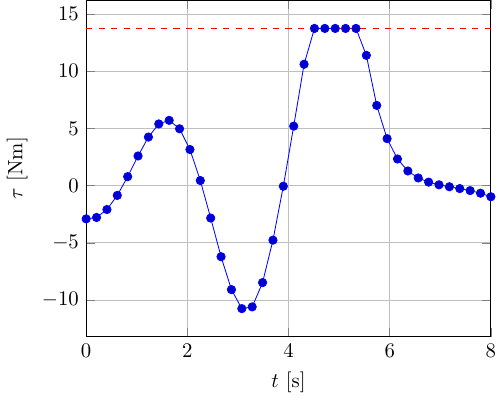

In [9]:
p = timeplot(t, τ; ylabel=L"$\tau$ [Nm]")
push!(p, @pgf HLine({dashed, red, thick}, τmax))
push!(p, @pgf HLine({dashed, red, thick}, -τmax))
p

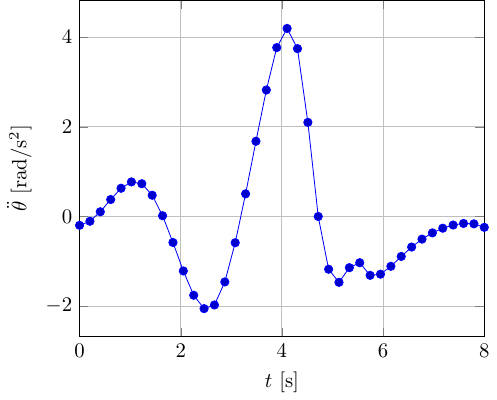

In [11]:
timeplot(t, θdd; ylabel=L"$\ddot{\theta}$ [rad/$\textrm{s}^2$]")